In [1]:
file_id_train = "17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT" #links = 2 (472827)events
file_id_val = "1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg" #links = 1 (920599)events

#!gdown https://drive.google.com/uc?id={file_id_train}
#!gdown https://drive.google.com/uc?id={file_id_val}
!ls

#!pip install nflows

 figures		       InfEraser.py	 papers        README.md
'images test reconstruction'   Originale.ipynb	 __pycache__   trasformation.py


In [2]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [57]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.base import InverseTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.permutations import RandomPermutation

from torch import optim
from sklearn import preprocessing
import trasformation
import InfEraser
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import torch
from os import stat
import sys


labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

index_int = np.append(np.arange(12,19),[22,23])
index_float = np.append(np.arange(0,12),np.arange(19,22))

In [4]:
x = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset.txt", delimiter=',')
L=len(x)
print(L)

472827


In [5]:
###LOG SU 0 E 3,STD SU TUTTE E QUATTRO LE FEATURES E QUANTILE SU 1,2

x = x[:int(L/16),:] #da mettere al massimo a 8 in colab
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]

print('Eventi =',len(x))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

xtr = np.copy(x)
xtrval = np.copy(xval)

r_q = ([1,2])
xtr = trasformation.prep(original=x, transformed=xtr, dir='forward', index_log=([0,3]), range_quantile=r_q, n_quantiles=10000)
xtrval = trasformation.prep(original=xval, transformed=xtrval, dir='forward', index_log=([0,3]), range_quantile=r_q, n_quantiles=10000)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Eventi = 29551
attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



/home/unipi/i.ditota/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


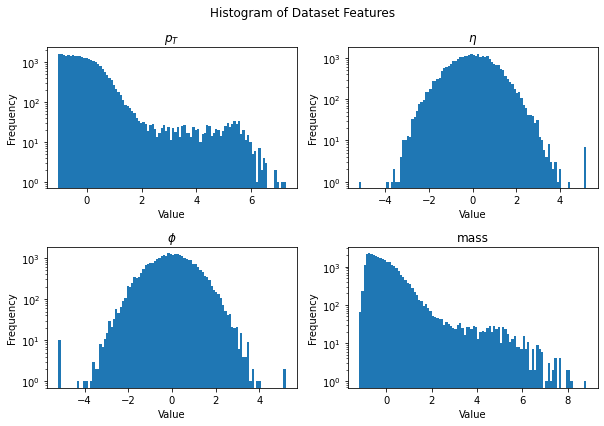

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Histogram of Dataset Features")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)


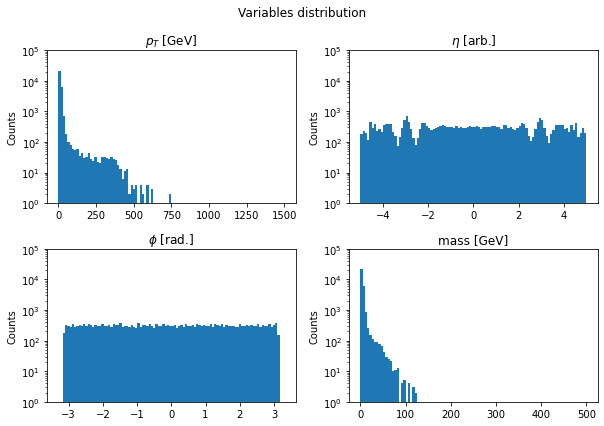

In [7]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

In [8]:
num_iterations = 8 #andrà messo a 8 su colab
num_features=4 #just for testing

base_dist = StandardNormal(shape=[num_features])

transforms = []
for _ in range(num_iterations):
  transforms.append(RandomPermutation(features=num_features))
  transforms.append(MaskedAffineAutoregressiveTransform(features=num_features,hidden_features=128))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
num_parameters = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print('Numero di parametri allenabili =',num_parameters)
optimizer = optim.Adam(flow.parameters())

flow = flow.to('cuda')

Numero di parametri allenabili = 541760


50 tensor(3.2509, device='cuda:0', grad_fn=<NegBackward0>)
100 tensor(3.0254, device='cuda:0', grad_fn=<NegBackward0>)
150 tensor(3.0040, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(2.9548, device='cuda:0', grad_fn=<NegBackward0>)
250 tensor(2.8467, device='cuda:0', grad_fn=<NegBackward0>)
300 tensor(2.8364, device='cuda:0', grad_fn=<NegBackward0>)
350 tensor(2.8253, device='cuda:0', grad_fn=<NegBackward0>)
400 tensor(2.7892, device='cuda:0', grad_fn=<NegBackward0>)
450 tensor(2.8476, device='cuda:0', grad_fn=<NegBackward0>)
500 tensor(2.8488, device='cuda:0', grad_fn=<NegBackward0>)
550 tensor(2.7940, device='cuda:0', grad_fn=<NegBackward0>)
600 tensor(2.7696, device='cuda:0', grad_fn=<NegBackward0>)
650 tensor(2.7606, device='cuda:0', grad_fn=<NegBackward0>)
700 tensor(2.7708, device='cuda:0', grad_fn=<NegBackward0>)
750 tensor(2.7549, device='cuda:0', grad_fn=<NegBackward0>)
800 tensor(2.7546, device='cuda:0', grad_fn=<NegBackward0>)
850 tensor(2.7624, device='cuda:0', grad_

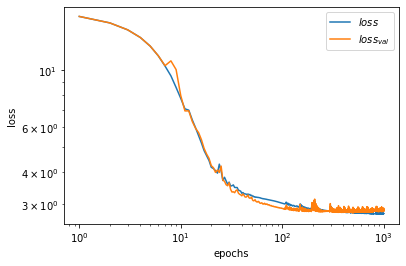

In [9]:
num_iter = 1000 #andrà messo a 10000 su colab

figloss=plt.figure()
loss_values = []
loss_validation = []
for i in range(num_iter):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 50 == 0:
    print(i+1,loss)

plt.plot(range(1, num_iter+1), loss_values, label='$loss$')
plt.plot(range(1, num_iter+1), loss_validation,label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

In [10]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = trasformation.prep(original=x, transformed=sample, dir='backward', index_log=([0,3]), range_quantile=r_q, n_quantiles=10000)

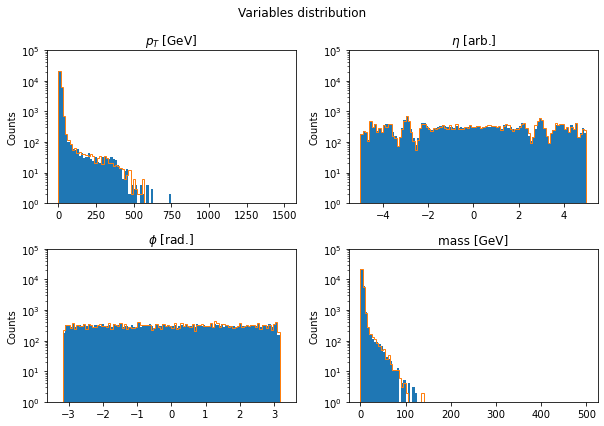

In [11]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].hist(sample[:,0],bins=n_bins, range=(0,1500),histtype='step')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step')
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step')
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].hist(sample[:,3],bins=n_bins, range=(0,500),histtype='step')
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_reconstruction.pdf',dpi=190)

In [12]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

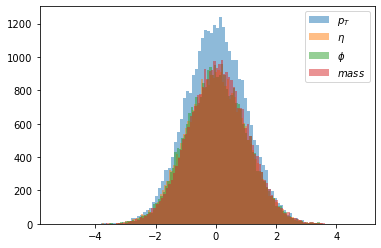

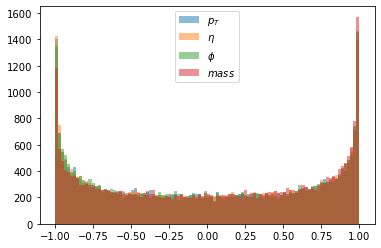

In [13]:
###COMPRESSING###
N = 11

gaus_tensor = flow.transform_to_noise(xt)
gaus = (gaus_tensor.cpu().detach().numpy())


figgaus=plt.figure()
plt.hist(gaus[:,0],bins=100,alpha=0.5, label='$p_T$')
plt.hist(gaus[:,1],bins=100,alpha=0.5, label='$\eta$')
plt.hist(gaus[:,2],bins=100,alpha=0.5, label='$\phi$')
plt.hist(gaus[:,3],bins=100,alpha=0.5, label='$mass$')
plt.legend()
plt.show()
figgaus.savefig('figures/Compression_gaus.pdf',dpi=190)

unif = scipy.special.erf(gaus)
unif = unif * 2**N
unif = unif.astype(int)
comp = unif/2**(N)   #compression

figunif=plt.figure()
plt.hist(comp[:,0],bins=100,alpha=0.5, label='$p_T$')
plt.hist(comp[:,1],bins=100,alpha=0.5, label='$\eta$')
plt.hist(comp[:,2],bins=100,alpha=0.5, label='$\phi$')
plt.hist(comp[:,3],bins=100,alpha=0.5, label='$mass$')
plt.legend()
plt.show()
figunif.savefig('figures/Compression_unif.pdf',dpi=190)

gaus_comp = scipy.special.erfinv(comp)
gaus_comp = InfEraser.inf_eraser(gaus_comp) #cancelliamo gli infiniti con l'apposita funzione
gaus_tensor_comp = torch.tensor(gaus_comp).to('cuda').float()
x_tensor_comp, _ = flow._transform.inverse(gaus_tensor_comp)
xcomp = x_tensor_comp.cpu().detach().numpy()

xcomp = trasformation.prep(original=x, transformed=xcomp, dir='backward', index_log=([0,3]), range_quantile=r_q, n_quantiles=10000)



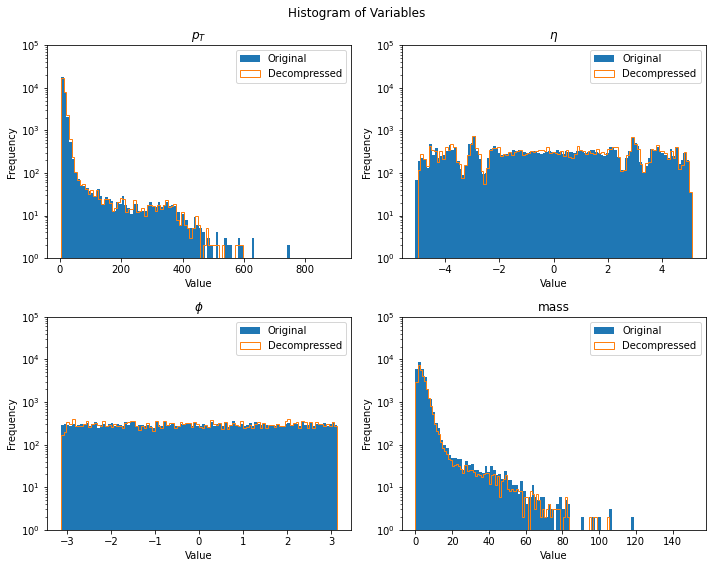

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Variables")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original',  log=True)
axs[0, 0].hist(xcomp[:, 0], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_ylim(1,10e4)
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', log=True)
axs[0, 1].hist(xcomp[:, 1], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_ylim(1,10e4)
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', log=True)
axs[1, 0].hist(xcomp[:, 2], bins=n_bins, label='Decompressed',histtype='step')
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', log=True)
axs[1, 1].hist(xcomp[:, 3], bins=n_bins, label='Decompressed', histtype='step')
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)


/tmp/ipykernel_63605/4026963625.py:22: RuntimeWarning: divide by zero encountered in true_divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
/tmp/ipykernel_63605/4026963625.py:22: RuntimeWarning: invalid value encountered in true_divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
/tmp/ipykernel_63605/4026963625.py:22: RuntimeWarning: divide by zero encountered in true_divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
/tmp/ipykernel_63605/4026963625.py:22: RuntimeWarning: invalid value encountered in true_divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


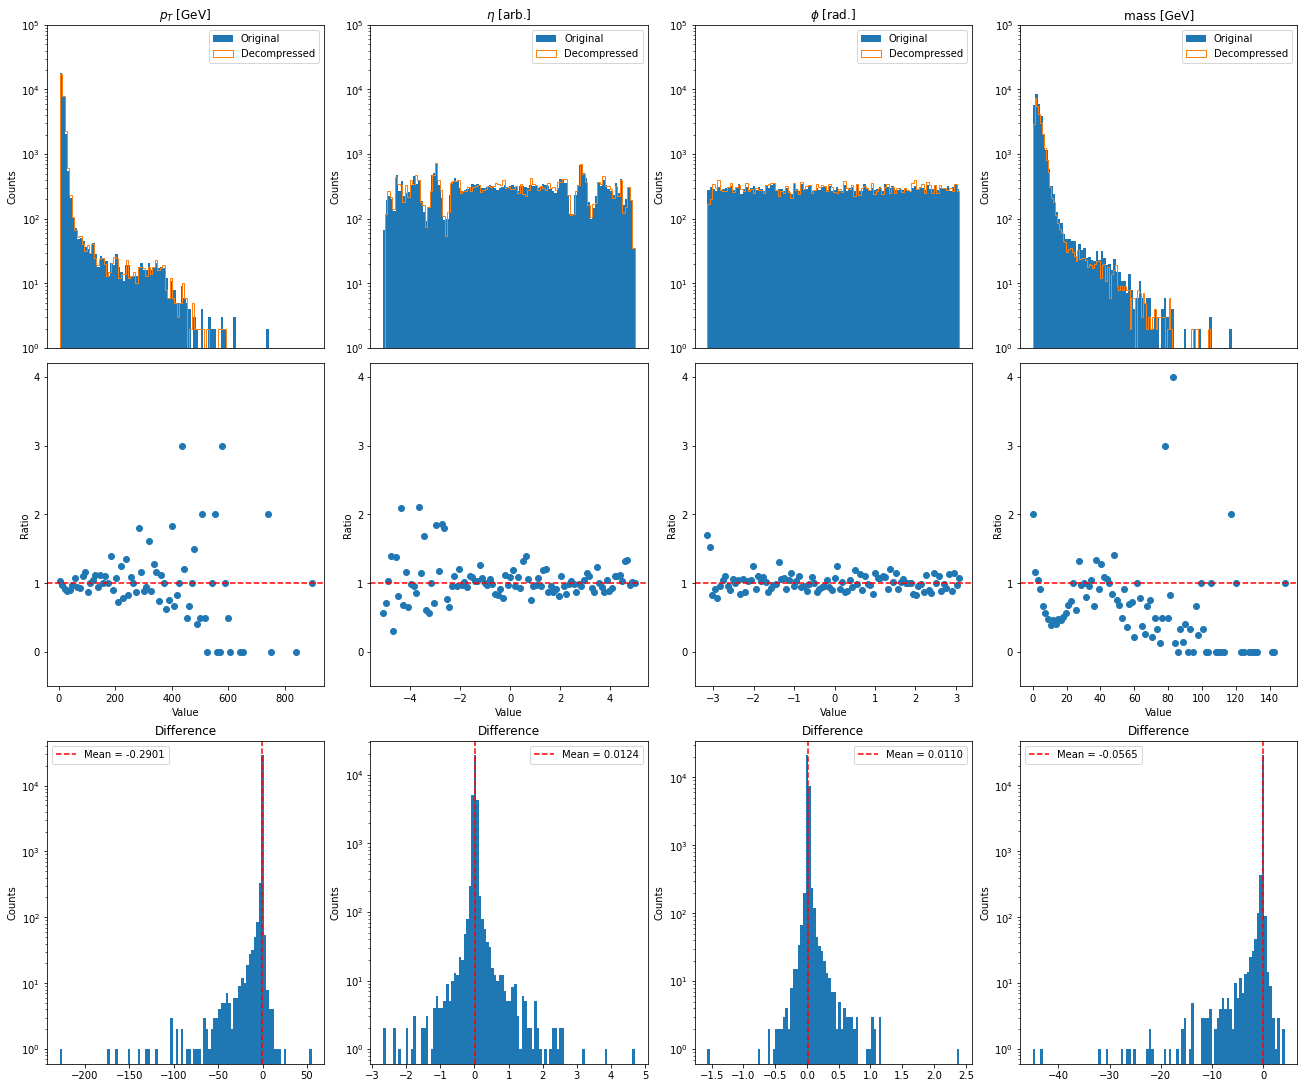

In [80]:
difference = xcomp-x

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots")

n_bins = 100

for i in range(4):
    y = []
    y.append(x[:, i])
    y.append(xcomp[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])

    
    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio")
    axs[1, i].set_ylim(-0.5,4.2)
    

    axs[2, i].hist(difference[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference.pdf', dpi=190)

In [ ]:
with open('/home/unipi/i.ditota/Desktop/dati/input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('/home/unipi/i.ditota/Desktop/dati/output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(xcomp[i, j]) for j in range(xcomp.shape[1])) + "\n")

with open('/home/unipi/i.ditota/Desktop/dati/compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(unif[i, j]) for j in range(unif.shape[1])) + "\n")


In [ ]:
size_input = stat('/home/unipi/i.ditota/Desktop/dati/input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('/home/unipi/i.ditota/Desktop/dati/output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('/home/unipi/i.ditota/Desktop/dati/compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio =',size_input/size_compressed)

Size of input file = 1.6123056411743164 MB
Size of output file = 1.1363029479980469 MB
Size of compressed file = 0.5746679306030273 MB
Compression ratio = 2.805630095771039


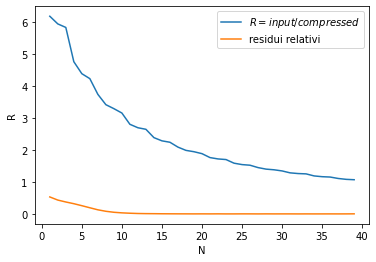

In [ ]:
RR = []
residui = []

modx = np.sum(np.abs(x))

for k in range(1,40):

    N = k

    gaus_tensor = flow.transform_to_noise(xt)
    gaus = (gaus_tensor.cpu().detach().numpy())

    unif = scipy.special.erf(gaus)
    unif = unif * 2**N
    unif = unif.astype(int)
    comp = unif/2**(N)   #compression
    gaus_comp = scipy.special.erfinv(comp)
    gaus_comp = InfEraser.inf_eraser(gaus_comp)


    gaus_tensor_comp = torch.tensor(gaus_comp).to('cuda').float()
    x_tensor_comp, _ = flow._transform.inverse(gaus_tensor_comp)
    xcomp = x_tensor_comp.cpu().detach().numpy()

    xcomp = trasformation.prep(original=x, transformed=xcomp, dir='backward', index_log=([0,3]), range_quantile=r_q, n_quantiles=10000)

    with open('/home/unipi/i.ditota/Desktop/dati/input.txt', 'w') as input:
        for i in range(len(x)):
            input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

    with open('/home/unipi/i.ditota/Desktop/dati/output.txt', 'w') as output:
        for i in range(len(x)):
            output.write(' '.join(str(xcomp[i, j]) for j in range(xcomp.shape[1])) + "\n")

    with open('/home/unipi/i.ditota/Desktop/dati/compressed.txt', 'w') as compressed:
        for i in range(len(x)):
            compressed.write(' '.join(str(unif[i, j]) for j in range(unif.shape[1])) + "\n")

    size_input = stat('/home/unipi/i.ditota/Desktop/dati/input.txt').st_size
    size_output = stat('/home/unipi/i.ditota/Desktop/dati/output.txt').st_size
    size_compressed = stat('/home/unipi/i.ditota/Desktop/dati/compressed.txt').st_size
    
    r_k = size_input/size_compressed
    RR.append(r_k)

    absresidui_k = np.sum(np.abs(x-xcomp))/modx
    residui.append(absresidui_k)

figratio=plt.figure()
plt.plot(range(1,k+1),RR,label='$R=input/compressed$')
plt.plot(range(1,k+1),residui,label='residui relativi')
plt.xlabel('N')
plt.ylabel('R')
plt.legend()
plt.show()

figratio.savefig('figures/Compression_ratio.pdf',dpi=190)
##aggiungere due scale diverse sulla y